In [2]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import torchvision

%matplotlib inline

## Model, scheduler and diffusion 

In [3]:
# use sinusoidal position embedding to encode time step (https://arxiv.org/abs/1706.03762)   
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

In [4]:
# define TimestepEmbedSequential to support `time_emb` as extra input
class TimestepBlock(nn.Module):
    """
    Any module where forward() takes timestep embeddings as a second argument.
    """

    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb):

        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x

# use GN for norm layer
def norm_layer(channels):
    return nn.GroupNorm(32, channels)

In [5]:
# Residual block
class ResidualBlock(TimestepBlock):
    def __init__(self, in_channels, out_channels, time_channels, dropout):
        super().__init__()
        self.conv1 = nn.Sequential(
            norm_layer(in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        # pojection for time step embedding
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            norm_layer(out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        )

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = nn.Identity()


    def forward(self, x, t):
        """
        `x` has shape `[batch_size, in_dim, height, width]`
        `t` has shape `[batch_size, time_dim]`
        """
        h = self.conv1(x)
        # Add time step embeddings
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.shortcut(x)

In [6]:
# Attention block with shortcut
class AttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()
        self.num_heads = num_heads
        assert channels % num_heads == 0
        
        self.norm = norm_layer(channels)
        self.qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.proj = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.reshape(B*self.num_heads, -1, H*W).chunk(3, dim=1)
        scale = 1. / math.sqrt(math.sqrt(C // self.num_heads))
        attn = torch.einsum("bct,bcs->bts", q * scale, k * scale)
        attn = attn.softmax(dim=-1)
        h = torch.einsum("bts,bcs->bct", attn, v)
        h = h.reshape(B, -1, H, W)
        h = self.proj(h)
        return h + x

In [7]:
# upsample
class Upsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):

        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x

# downsample
class Downsample(nn.Module):
    def __init__(self, channels, use_conv):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
            self.op = nn.AvgPool2d(stride=2)

    def forward(self, x):
        return self.op(x)

In [8]:
# The full UNet model with attention and timestep embedding
class UNetModel(nn.Module):
    def __init__(
        self,
        in_channels=3,
        model_channels=128,
        out_channels=3,
        num_res_blocks=2,
        attention_resolutions=(8, 16),
        dropout=0.0,
        channel_mult=(1, 2, 2, 2),
        conv_resample=True,
        num_heads=4
    ):
        super().__init__()

        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        
        # time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # down blocks
        self.down_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1))
        ])
        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [
                    ResidualBlock(ch, mult * model_channels, time_embed_dim, dropout)
                ]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1: # don't use downsample for the last stage
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2
        
        # middle block
        self.middle_block = TimestepEmbedSequential(
            ResidualBlock(ch, ch, time_embed_dim, dropout),
            AttentionBlock(ch, num_heads=num_heads),
            ResidualBlock(ch, ch, time_embed_dim, dropout)
        )
        
        # up blocks
        self.up_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        ch + down_block_chans.pop(),
                        model_channels * mult,
                        time_embed_dim,
                        dropout
                    )
                ]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            norm_layer(ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x ...] Tensor of outputs.
        """
        hs = []
        # time step embedding
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        
        # down stage
        h = x
        for module in self.down_blocks:
            h = module(h, emb)
            hs.append(h)
        # middle stage
        h = self.middle_block(h, emb)
        # up stage
        for module in self.up_blocks:
            cat_in = torch.cat([h, hs.pop()], dim=1)
            h = module(cat_in, emb)
        return self.out(h)

In [9]:
# beta schedule
def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps, dtype=torch.float64)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

In [10]:
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        timesteps=1000,
        beta_schedule='linear'
    ):
        self.timesteps = timesteps
        
        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        self.betas = betas
            
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.)
        self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)
        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning
        # of the diffusion chain
        #self.posterior_log_variance_clipped = torch.log(self.posterior_variance.clamp(min =1e-20))
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]])
        )
        
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev)
            * torch.sqrt(self.alphas)
            / (1.0 - self.alphas_cumprod)
        )
    
    # get the param of given timestep t
    def _extract(self, a, t, x_shape):
        batch_size = t.shape[0]
        out = a.to(t.device).gather(0, t).float()
        out = out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))
        return out
    
    # forward diffusion (using the nice property): q(x_t | x_0)
    def q_sample(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)

        sqrt_alphas_cumprod_t = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = self._extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)

        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    # Get the mean and variance of q(x_t | x_0).
    def q_mean_variance(self, x_start, t):
        mean = self._extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = self._extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = self._extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance
    
    # Compute the mean and variance of the diffusion posterior: q(x_{t-1} | x_t, x_0)
    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (
            self._extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + self._extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = self._extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = self._extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped
    
    # compute x_0 from x_t and pred noise: the reverse of `q_sample`
    def predict_start_from_noise(self, x_t, t, noise):
        return (
            self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
            self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    # compute predicted mean and variance of p(x_{t-1} | x_t)
    def p_mean_variance(self, model, x_t, t, clip_denoised=True):
        # predict noise using model
        pred_noise = model(x_t, t)
        # get the predicted x_0: different from the algorithm2 in the paper
        x_recon = self.predict_start_from_noise(x_t, t, pred_noise)
        if clip_denoised:
            x_recon = torch.clamp(x_recon, min=-1., max=1.)
        model_mean, posterior_variance, posterior_log_variance = \
                    self.q_posterior_mean_variance(x_recon, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance
        
    # denoise_step: sample x_{t-1} from x_t and pred_noise
    # @torch.no_grad()
    def p_sample(self, model, x_t, t, clip_denoised=True):
        # predict mean and variance
        model_mean, _, model_log_variance = self.p_mean_variance(model, x_t, t,
                                                    clip_denoised=clip_denoised)
        noise = torch.randn_like(x_t)
        # no noise when t == 0
        nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(x_t.shape) - 1))))
        # compute x_{t-1}
        pred_img = model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise
        return pred_img
    
    # denoise: reverse diffusion
    # @torch.no_grad()
    def p_sample_loop(self, model, shape, noise=None):
        batch_size = shape[0]
        device = next(model.parameters()).device
        # start from pure noise (for each example in the batch)
        if noise==None:
            img = torch.randn(shape, device=device)
        else:
            img = noise
            shape=noise.shape
        imgs = []
        for i in tqdm(reversed(range(0, self.timesteps)), desc='sampling loop time step', total=self.timesteps):
            img = self.p_sample(model, img, torch.full((batch_size,), i, device=device, dtype=torch.long))
            imgs.append(img)
        return imgs
    
    # sample new images
    # @torch.no_grad()
    def ddpm_sample(self, model, image_size, batch_size=8, channels=3, noise=None):
        return self.p_sample_loop(model, shape=(batch_size, channels, image_size, image_size), noise=noise)
    
    
    # @torch.no_grad()
    def ddim_sample_loop(
        self,
        model,
        shape, 
        noise, 
        device,
        clip_denoised=True,
        eta=0.0,):

        final = None 
        for sample in self.ddim_sample_loop_progressive(
                model, shape, noise, device, clip_denoised=clip_denoised, eta=eta):
            final = sample
        return final
    

    # @torch.no_grad()
    def ddim_sample_loop_progressive(self,
                model, shape, noise, device, clip_denoised=True, eta=0.0):
        
        if noise is not None:
            img = noise
        else:
            img = torch.randn(*shape, device=device)

        indices = list(range(self.timesteps))[::-1]

        for i in tqdm(indices, desc='ddim sampling loop', total=self.timesteps):
            t = torch.tensor([i] * shape[0], device=device)
            out = self.ddim_sample(
                model,
                img,
                t,
                clip_denoised=clip_denoised,
                eta=eta,
            )
            yield out
            img = out        
    
    # @torch.no_grad()
    def ddim_sample(self,
                model,
                x,
                t,
                clip_denoised=True,
                eta=0.0,
            ):
        model_output = model(x, t)
        pred_xstart = self.predict_start_from_noise(x, t, model_output)

        if clip_denoised:
            pred_xstart = pred_xstart.clamp(-1, 1)

        eps = self._predict_eps_from_xstart(x, t, pred_xstart)

        alpha_bar =  self._extract(self.alphas_cumprod, t, x.shape)
        alpha_bar_prev =  self._extract(self.alphas_cumprod_prev, t, x.shape)

        sigma = (eta* torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))* torch.sqrt(1 - alpha_bar / alpha_bar_prev))

        # Equation 12.
        noise = torch.randn_like(x)

        mean_pred = (
                pred_xstart * torch.sqrt(alpha_bar_prev)
                + torch.sqrt(1 - alpha_bar_prev - sigma ** 2) * eps
        )

        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )

        sample = mean_pred + nonzero_mask * sigma * noise
        return sample


    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (
                       self._extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
                       - pred_xstart
               ) / self._extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    @torch.no_grad()
    def ddim_reverse_sample_loop(
        self,
        model, 
        image, 
        device,
        clip_denoised=False,
        eta=0.0,):

        final = None
        for sample in self.ddim_reverse_sample_loop_progressive(
                model, image, device, clip_denoised=clip_denoised, eta=eta):
            final = sample
        return final
            


    @torch.no_grad()
    def ddim_reverse_sample_loop_progressive(
        self,
        model, 
        image, 
        device,
        clip_denoised=False,
        eta=0.0,):


        shape = image.shape
        indices = list(range(self.timesteps))

        for i in tqdm(indices, desc='ddim reverse sampling loop', total=self.timesteps):
            t = torch.tensor([i] * shape[0], device=device)
            out = self.ddim_reverse_sample(
                model,
                image,
                t,
                clip_denoised=clip_denoised,
                eta=eta,
            )
            yield out
            image = out
    
    @torch.no_grad()
    def ddim_reverse_sample(
            self,
            model,
            x,
            t,
            clip_denoised=True,
            eta=0.0):
        assert eta == 0.0
        

        model_output = model(x, t)

        pred_xstart = self.predict_start_from_noise(x, t, model_output)
        
        if clip_denoised:
            pred_xstart = pred_xstart.clamp(-1, 1)
        
        eps = (self._extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
               - pred_xstart) / self._extract(self.sqrt_recipm1_alphas_cumprod, t, x.shape)

        alpha_bar_next = self._extract(torch.from_numpy(self.alphas_cumprod_next), t, x.shape)
        mean_pred = pred_xstart* torch.sqrt(alpha_bar_next) + torch.sqrt(1 - alpha_bar_next) * eps
        return mean_pred

    # compute train losses
    def train_losses(self, model, x_start, t):
        # generate random noise
        noise = torch.randn_like(x_start)
        # get x_t
        x_noisy = self.q_sample(x_start, t, noise=noise)
        predicted_noise = model(x_noisy, t)
        loss = F.mse_loss(noise, predicted_noise)
        return loss

In [11]:
from torchvision.datasets import MNIST
import random
import matplotlib.colors as mcolors

class ColoredMNIST(MNIST):
    def __init__(self, root, train=True, download=False, transform=None, target_transform=None, target_digit=2, use_cmap=True):
        super(ColoredMNIST, self).__init__(root, train=train, download=download, transform=transform,
                                           target_transform=target_transform)

        self.target_digit = target_digit
        self.target_indx = (self.targets == target_digit)
        new_indices = torch.squeeze(self.target_indx.nonzero())
        self.data = self.data[new_indices]
        self.targets = self.targets[new_indices]
        self.use_cmap = use_cmap
        self.data = self.data
        # print(len(self.data))
        self.targets = self.targets

    def __getitem__(self, index):
        img, label = self.data[index], self.targets[index]
        img = img.numpy()

        if self.use_cmap:
            cmap = mcolors.TABLEAU_COLORS.values()

            rnd_color = random.randint(0,len(cmap))-1
            determenistic_color =  int(index // (len(self.data)/len(mcolors.TABLEAU_COLORS.values())))

            h = list(cmap)[determenistic_color].lstrip('#')
            color = tuple( int(h[i:i+2], 16) for i in (0, 2, 4) ) 
        else:
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        img = np.stack((img, img, img), axis=2)

        img[:, :, 0] = img[:, :, 0] / 255 * color[0]
        img[:, :, 1] = img[:, :, 1] / 255 * color[1]
        img[:, :, 2] = img[:, :, 2] / 255 * color[2]
        # img = np.where(img > 0, color, img)
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

## Colored mnist dataset

In [12]:
# copied from https://github.com/ngushchin/EntropicNeuralOptimalTransport/blob/06efb6ba8b43865a30b0b626384fa64da39bc385/src/tools.py#L31
def get_random_colored_images(images, seed = 0x000000):
    np.random.seed(seed)
    
    images = 0.5*(images + 1)
    size = images.shape[0]
    colored_images = []
    hues = 360*np.random.rand(size)
    
    for V, H in zip(images, hues):
        V_min = 0
        
        a = (V - V_min)*(H%60)/60
        V_inc = a
        V_dec = V - a
        
        colored_image = torch.zeros((3, V.shape[1], V.shape[2]))
        H_i = round(H/60) % 6
        
        if H_i == 0:
            colored_image[0] = V
            colored_image[1] = V_inc
            colored_image[2] = V_min
        elif H_i == 1:
            colored_image[0] = V_dec
            colored_image[1] = V
            colored_image[2] = V_min
        elif H_i == 2:
            colored_image[0] = V_min
            colored_image[1] = V
            colored_image[2] = V_inc
        elif H_i == 3:
            colored_image[0] = V_min
            colored_image[1] = V_dec
            colored_image[2] = V
        elif H_i == 4:
            colored_image[0] = V_inc
            colored_image[1] = V_min
            colored_image[2] = V
        elif H_i == 5:
            colored_image[0] = V
            colored_image[1] = V_min
            colored_image[2] = V_dec
        
        colored_images.append(colored_image)
        
    colored_images = torch.stack(colored_images, dim = 0)
    colored_images = 2*colored_images - 1
    
    return colored_images


In [13]:
from torchvision.datasets import MNIST


class ColoredMNIST(MNIST):
    def __init__(self, root, train=True, download=False, transform=None, target_transform=None, target_digit=2):
        super(ColoredMNIST, self).__init__(root, train=train, download=download, transform=transform,
                                           target_transform=target_transform)

        data = []
        data.append(torch.stack(
            [self.transform(Image.fromarray(self.data[i].numpy())) 
             for i in range(len(self.targets)) 
             if self.targets[i] == target_digit],
            dim=0
        ))
        self.data = torch.cat(data, dim=0)
        self.data = get_random_colored_images(self.data)
        
        self.targets = self.targets[self.targets == target_digit]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        
        return img, target

    def __len__(self): return len(self.data)

batch_size = 64
timesteps = 500

transform = transforms.Compose([
    transforms.Pad((2, 2)),
    transforms.ToTensor(),
    # transforms.Resize(32,),# interpolation=torchvision.transforms.InterpolationMode.NEAREST_EXACT   
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
# train_loader = torch.utils.data.DataLoader(colored_mnist_3, batch_size=batch_size, shuffle=True)

colored_mnist_2 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=2)
train_loader = torch.utils.data.DataLoader(colored_mnist_2, batch_size=batch_size, shuffle=False)


## Determine diffusion and model parameters

In [16]:
# define model and diffusion
gaussian_diffusion = GaussianDiffusion(timesteps=timesteps, beta_schedule='linear')
device = "cuda" if torch.cuda.is_available() else "cpu"


model = UNetModel(
    in_channels=3,
    model_channels=128,
    out_channels=3,
    channel_mult=(1, 2, 2, 2),
    num_res_blocks=4,
    attention_resolutions=(16,),
    dropout = 0.1,
    conv_resample=True,  
)
model.to(device);



## Visualise source images

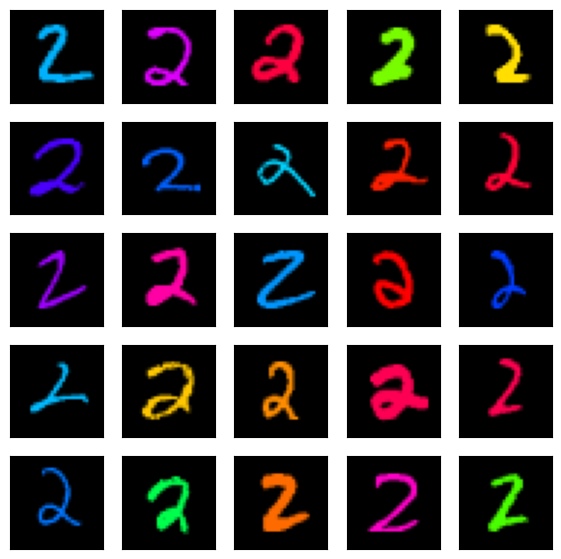

In [14]:
for batch, _ in train_loader:
    batch = batch.permute(0, 2, 3, 1)
    # batch = torch.randn_like(batch).clamp(min=-1, max=1)
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(7, 7),
                                subplot_kw={'xticks': [], 'yticks': []})
    for i in range(25):      
        axes[i % 5, (i // 5)].imshow(batch[i]*0.5+0.5)
    break

## Check noise encoder

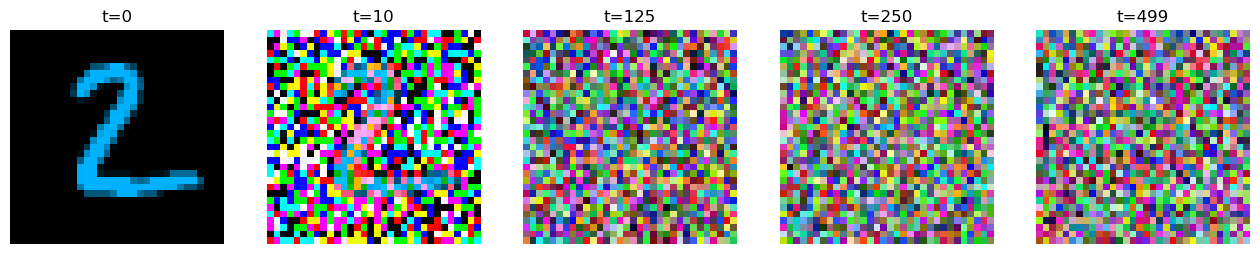

In [15]:
image = next(iter(train_loader))[0][0].squeeze()
label = next(iter(train_loader))[1][0].squeeze()

x_start = image


plt.figure(figsize=(16, 5))
for idx, t in enumerate([0, 10, timesteps//4, timesteps//2, timesteps-1]):
    x_noisy = gaussian_diffusion.q_sample(x_start.to(device), t=torch.tensor([t]).to(device))
    noisy_image = (x_noisy.squeeze() + 1) * 127.5
    
    if idx==0:
        noisy_image = (x_start.squeeze() + 1) * 127.5
    
    noisy_image = noisy_image.cpu().numpy().astype(np.uint8)

    noisy_image = np.einsum('ijk->jki', noisy_image)

    
    plt.subplot(1, 5, 1 + idx)
    plt.imshow(noisy_image)
    plt.axis("off")
    plt.title(f"t={t}")


## Training diffuison model

In [16]:
# train
import pytorch_warmup as warmup

warmup_period = 4000
epochs = 1000
len_data = len(train_loader)
time_end = time.time()

# optimizer = torch.optim.Adam(model.parameters(), lr=6e-5, betas=)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002, betas=(0.9, 0.999), weight_decay=0.01)
num_steps = len(train_loader) * epochs - warmup_period
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)

for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):
        time_start = time_end
        optimizer.zero_grad()
        
        batch_size = images.shape[0]
        images = images.to(device)
        
        # sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        
        loss = gaussian_diffusion.train_losses(model, images, t)
        

        if step % 100 == 0:
            time_end = time.time()
            print("Epoch {}/{}\t Loss {:.4f}\t Time {:.2f}\t LR {}".format(
                epoch+1, epochs, loss.item(), time_end-time_start, lr_scheduler.get_last_lr()[0]))
            
        loss.backward()
        optimizer.step()
        with warmup_scheduler.dampening():
            if warmup_scheduler.last_step + 1 >= warmup_period:
                lr_scheduler.step()

In [17]:
# if not os.path.exists('./saved_models'):
#     os.mkdir('./saved_models')
# torch.save(model, './saved_models/model_cmnist_2_new.pth')

In [18]:
def plot_translations(initial, latent, generated, N_rows, N_columns):
    
    initial = (initial.permute(0, 2, 3, 1).cpu()+1)* 127.5
    latent = (latent.permute(0, 2, 3, 1).cpu()+1)* 127.5
    generated = (generated.permute(0, 2, 3, 1).cpu()+1)* 127.5
    
    for idx_row in range(N_rows):
        fig, axes = plt.subplots(nrows=3, ncols=N_columns, figsize=(10, 5),
                                subplot_kw={'xticks': [], 'yticks': []})
        for i in range(N_columns):      
            axes[0, (i)].imshow(initial[N_columns*idx_row + i].type(torch.uint8))
            axes[1, (i)].imshow(latent[N_columns*idx_row + i].type(torch.uint8))
            axes[2, (i)].imshow(generated[N_columns*idx_row + i].type(torch.uint8))

In [19]:
model_2 = torch.load('model_2.pth').to(device);
model_2.eval()

gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear');

In [25]:
def plot_translations_latents(initial, latent, latent_tr, gen_tr, gen_init, N_rows, N_columns):
    
    initial = (initial.permute(0, 2, 3, 1).cpu()+1)* 127.5
    latent = (latent.permute(0, 2, 3, 1).cpu()+1)* 127.5
    
    latent_tr = (latent_tr.permute(0, 2, 3, 1).cpu()+1)* 127.5
    gen_tr = (gen_tr.permute(0, 2, 3, 1).cpu()+1)* 127.5
    gen_init = (gen_init.permute(0, 2, 3, 1).cpu()+1)* 127.5
    
    for idx_row in range(N_rows):
        fig, axes = plt.subplots(nrows=5, ncols=N_columns, figsize=(int(N_columns*1.4), 6),
                                subplot_kw={'xticks': [], 'yticks': []})
        for i in range(N_columns):      
            axes[0, (i)].imshow(initial[N_columns*idx_row + i].type(torch.uint8))
            axes[1, (i)].imshow(latent[N_columns*idx_row + i].type(torch.uint8))
            axes[2, (i)].imshow(latent_tr[N_columns*idx_row + i].type(torch.uint8))
            axes[3, (i)].imshow(gen_tr[N_columns*idx_row + i].type(torch.uint8))
            axes[4, (i)].imshow(gen_init[N_columns*idx_row + i].type(torch.uint8))


## Latent Transfrom

In [14]:
class conv_block(nn.Module):
    """
    Convolution Block 
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
    

    

class U_Net(nn.Module):
    """
    UNet - Basic Implementation
    Paper : https://arxiv.org/abs/1505.04597
    """
    def __init__(self, in_ch=3, out_ch=1):
        super(U_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]
        
        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

       # self.active = torch.nn.Sigmoid()

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        d5 = torch.cat((e4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        #d1 = self.active(out)

        return out


## Color extraction and loss

In [34]:
def extract_color(img):
    
    assert len(img.shape) == 4  
    batch_size = img.shape[0]

    img = torch.clamp(img, min=-1., max=1.)
    img = (img.permute(0, 2, 3, 1)+ 1) * 127.5

    
    # img = img.type(torch.uint8).type(torch.float)
    color = torch.zeros((batch_size,3))
    for idx_batch in range(batch_size):        
        pixel_avg = img[idx_batch, ...].sum(axis=2).flatten()
        
        color[idx_batch,:] = img[idx_batch, ...].reshape(-1, 3)[pixel_avg != 0,:].mean(0)

    return color

In [ ]:

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.loss = piq.LPIPS()
        self.loss = nn.MSELoss()
        # # self.diffusion_model = d_model
        # for param in self.diffusion_model.parameters():
        #     param.requires_grad = False

        # self.gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')

    def forward(self,y, yhat):
        batch_size = y.shape[0]
        y = extract_color(y)
        yhat = extract_color(yhat)
        

        loss = self.loss(y, yhat)
        return loss

In [ ]:
LTmodel = torch.load('./saved_models/LTmodel.pth').to(device);

## Training Latent transformation model

In [ ]:
from torch.utils.checkpoint import checkpoint_sequential

batch_size = 4
# Initialize models, optimizer, and loss
# colored_mnist_2 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=2)
# train_loader_2 = torch.utils.data.DataLoader(colored_mnist_2, batch_size=batch_size, shuffle=False, drop_last=True)

colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
train_loader_3 = torch.utils.data.DataLoader(colored_mnist_3, batch_size=batch_size, shuffle=True, drop_last=True)

latent_dim = 8
# encoder = Encoder(latent_dim=latent_dim).to(device)
# decoder = Decoder(latent_dim=latent_dim).to(device)

LTmodel = U_Net(in_ch=3, out_ch=3).to(device)

# criterion = nn.MSELoss()
# criterion = CustomLoss(model_2)
criterion = CustomLoss()
optimizer = torch.optim.Adam(list(LTmodel.parameters()), lr=0.0001)

# Training loop
epochs = 10
gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')
LTmodel.train()
for param in model_2.parameters():
    param.requires_grad = False

for epoch in range(epochs):
    # for (images2, _), (images3, _) in zip(train_loader_2, train_loader_3):
    for images3, _ in train_loader_3:
        # images2 = images2.to(device)
        images3 = images3.to(device)
        
        # images2 = gaussian_diffusion.q_sample(images2, t=torch.tensor([400]).to(device))
        latent_dm = gaussian_diffusion.q_sample(images3, t=torch.randint(0, 500-1, (1,)).to(device))
        # Forward pass
        latent_tr = LTmodel(latent_dm)
        # Compute loss
        gaussian_diffusion.timesteps = 40

        gen = gaussian_diffusion.ddim_sample_loop(model_2, (batch_size, 3, 32, 32), latent_tr, device, clip_denoised=True, eta=0.2)
        loss = criterion(gen, images3)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


In [37]:
# torch.save(LTmodel, './saved_models/LTmodel.pth')

In [17]:
LTmodel = torch.load('./saved_models/LTmodel_full_train.pth').to(device);

## Inference

sampling loop time step: 100% 500/500 [00:05<00:00, 93.70it/s] 
sampling loop time step: 100% 500/500 [00:04<00:00, 100.17it/s]


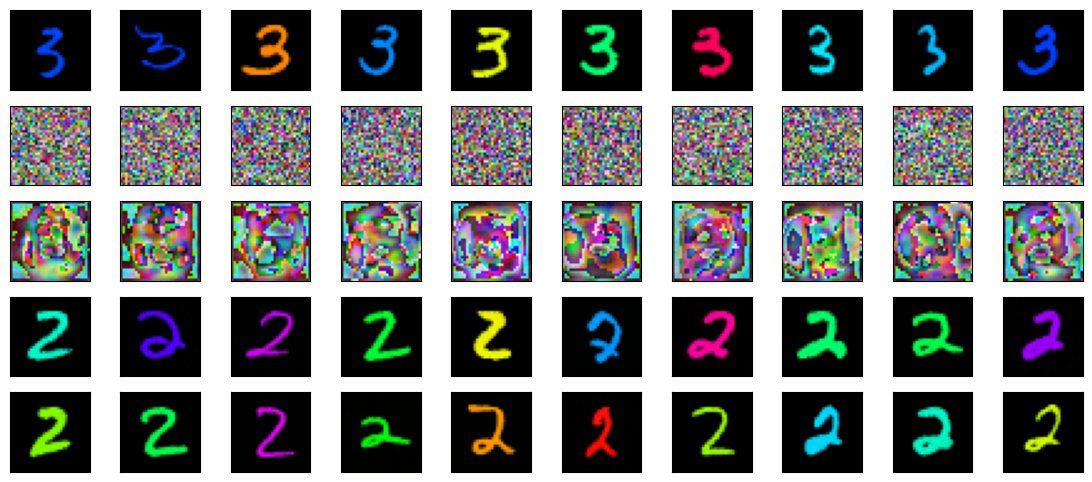

In [ ]:
# torch.manual_seed(1) #14

N_rows = 1
N_columns = 10
N_pic = N_rows*N_columns
timesteps = 500

colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
train_loader_3 = torch.utils.data.DataLoader(colored_mnist_3, batch_size=N_pic, shuffle=True, drop_last=True)


model_2.eval()
LTmodel.eval()
with torch.no_grad():

    for batch, _ in train_loader_3:
        img = batch.to(device)
        
        gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')
        # forward DDPM
        latent_df = gaussian_diffusion.q_sample(img[:N_pic,...], t=torch.tensor([50]).to(device))
        # latent_tr = latent_df
        latent_tr = LTmodel(latent_df)
        
        gaussian_diffusion.timesteps = 500

        
        # ddim_gen = gaussian_diffusion.ddim_sample_loop(model_2, (N_pic, 3, 32, 32), latent_tr, device, clip_denoised=True, eta=1)
        
        ddpm_gen_tr = gaussian_diffusion.ddpm_sample(model_2, 32, batch_size=N_pic, channels=3, noise=latent_tr)[-1]
        ddpm_gen_init = gaussian_diffusion.ddpm_sample(model_2, 32, batch_size=N_pic, channels=3, noise=latent_df)[-1]

        plot_translations_latents(batch, latent_df, latent_tr, ddpm_gen_tr, ddpm_gen_init, N_rows, N_columns)

        # plot_translations_latents(batch, latent_df, latent_tr, gaussian_diffusion.ddim_sample_loop(model_2, (N_pic, 3, 32, 32), latent_df, device, clip_denoised=True, eta=0.5), N_rows, N_columns)

        break

# Calculate metrics

## Color transform

In [24]:
def extract_color(img):
    
    assert len(img.shape) == 4  
    batch_size = img.shape[0]

    img = torch.clamp(img, min=-1., max=1.)
    img = (img.permute(0, 2, 3, 1)+ 1) * 127.5

    
    # img = img.type(torch.uint8).type(torch.float)
    color = torch.zeros((batch_size,3))
    for idx_batch in range(batch_size):        
        pixel_avg = img[idx_batch, ...].sum(axis=2).flatten()
        
        color[idx_batch,:] = img[idx_batch, ...].reshape(-1, 3)[pixel_avg != 0,:].mean(0)

    return color


def calculate_detailed_color_metrics(dataloader, LTmodel, model_2, gaussian_diffusion, device):
    color_differences = []

    with torch.no_grad():
        for batch, _ in dataloader:
            img = batch.to(device)
            latent_df = gaussian_diffusion.q_sample(img, t=torch.tensor([50]).to(device))
            latent_tr = LTmodel(latent_df)

            gaussian_diffusion.timesteps = 500

            transformed_images = gaussian_diffusion.ddpm_sample(model_2, 32, batch_size=img.shape[0], channels=3, noise=latent_tr)[-1]
            
            original_colors = extract_color(img)
            transformed_colors = extract_color(transformed_images)
    
            color_diff = torch.abs(original_colors - transformed_colors).mean(dim=1)
            color_diff = color_diff / 255.0
    
            color_differences.append(color_diff)

    all_differences = torch.cat(color_differences)
    
    return {
        'overall_mean': all_differences.mean().item(),
        'overall_std': all_differences.std().item(),
        'all_differences': all_differences
    }


In [53]:
batch_size = 512

colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
train_loader = torch.utils.data.DataLoader(colored_mnist_3, batch_size=batch_size, shuffle=True)

result = calculate_detailed_color_metrics(train_loader, LTmodel, model_2, gaussian_diffusion, device)

sampling loop time step: 100% 500/500 [03:52<00:00,  2.15it/s]
sampling loop time step: 100% 500/500 [03:46<00:00,  2.21it/s]


In [57]:
result["all_differences"]

tensor([0.2834, 0.1879, 0.3292,  ..., 0.2825, 0.3303, 0.3332])

## For different timestemps


In [45]:
def extract_color(img):
    
    assert len(img.shape) == 4  
    batch_size = img.shape[0]

    img = torch.clamp(img, min=-1., max=1.)
    img = (img.permute(0, 2, 3, 1)+ 1) * 127.5

    
    # img = img.type(torch.uint8).type(torch.float)
    color = torch.zeros((batch_size,3))
    for idx_batch in range(batch_size):        
        pixel_avg = img[idx_batch, ...].sum(axis=2).flatten()
        
        color[idx_batch,:] = img[idx_batch, ...].reshape(-1, 3)[pixel_avg != 0,:].mean(0)

    return color


def calculate_detailed_color_metrics(dataloader, LTmodel, model_2, gaussian_diffusion, device, timestep=50):
    color_differences = []

    with torch.no_grad():
        for batch, _ in dataloader:
            img = batch.to(device)
            latent_df = gaussian_diffusion.q_sample(img, t=torch.tensor([timestep]).to(device))
            latent_tr = LTmodel(latent_df)

            gaussian_diffusion.timesteps = 500

            transformed_images = gaussian_diffusion.ddpm_sample(model_2, 32, batch_size=img.shape[0], channels=3, noise=latent_tr)[-1]
            
            original_colors = extract_color(img)
            transformed_colors = extract_color(transformed_images)
    
            color_diff = torch.abs(original_colors - transformed_colors).mean(dim=1)
            color_diff = color_diff / 255.0
    
            color_differences.append(color_diff)

    all_differences = torch.cat(color_differences)
    
    return all_differences.mean().item()


In [ ]:
import json
timestamps = [50, 100, 200, 250, 300, 400, 499]

batch_size = 512

colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
train_loader = torch.utils.data.DataLoader(colored_mnist_3, batch_size=batch_size, shuffle=False)

results = {}
for t in timestamps:
    color_mean = calculate_detailed_color_metrics(
        train_loader, 
        LTmodel, 
        model_2, 
        gaussian_diffusion, 
        device,
        t,
    )
    results[str(t)] = float(color_mean)
    
    with open('results.json', 'w') as f:
        json.dump(results, f, indent=4)

sampling loop time step: 100% 500/500 [02:05<00:00,  4.00it/s]
sampling loop time step: 100% 500/500 [02:21<00:00,  3.52it/s]
sampling loop time step: 100% 500/500 [03:32<00:00,  2.35it/s]
sampling loop time step: 100% 500/500 [03:24<00:00,  2.45it/s]
sampling loop time step: 100% 500/500 [03:53<00:00,  2.14it/s]
sampling loop time step: 100% 500/500 [03:40<00:00,  2.26it/s]
sampling loop time step: 100% 500/500 [03:52<00:00,  2.15it/s]
sampling loop time step: 100% 500/500 [03:58<00:00,  2.10it/s]
sampling loop time step: 100% 500/500 [03:37<00:00,  2.30it/s]
sampling loop time step: 100% 500/500 [02:44<00:00,  3.04it/s]
sampling loop time step: 100% 500/500 [02:07<00:00,  3.92it/s]
sampling loop time step: 100% 500/500 [02:04<00:00,  4.00it/s]
sampling loop time step:  96% 481/500 [03:28<00:09,  2.06it/s]

In [9]:
with open('results.json', 'r') as file:
    results = json.load(file)

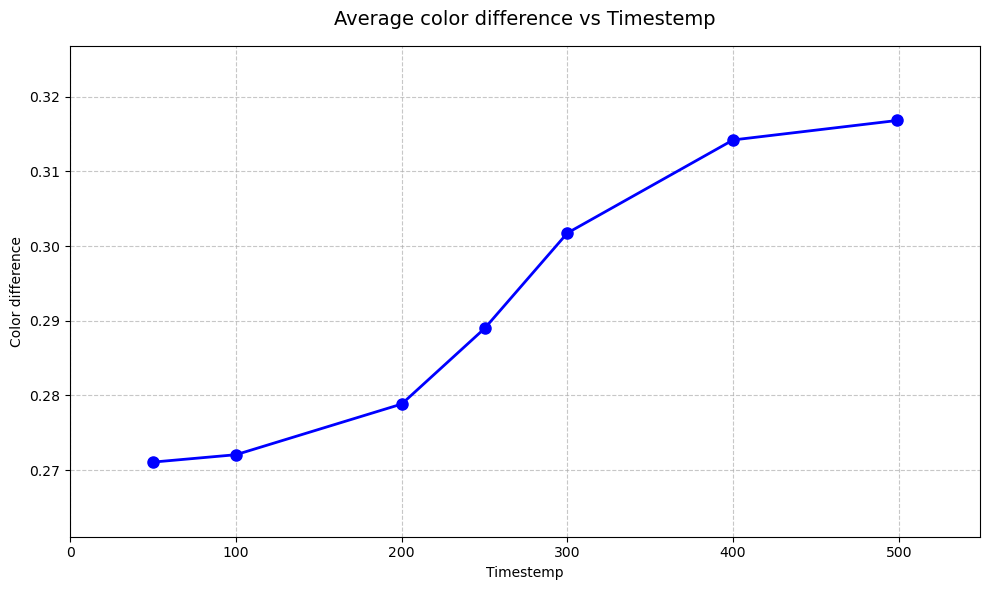

In [12]:
x = [int(k) for k in results.keys()]
y = list(results.values())

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-o', linewidth=2, markersize=8)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels and title
plt.xlabel('Timestemp')
plt.ylabel('Color difference')
plt.title('Average color difference vs Timestemp', fontsize=14, pad=15)

# Customize axes
plt.xlim(0, max(x) + 50)
plt.ylim(min(y) - 0.01, max(y) + 0.01)

# Show the plot
plt.tight_layout()
plt.show()

## FID

In [ ]:
!pip install pytorch-fid

In [ ]:
import torch
from torchvision.datasets import MNIST
from pytorch_fid import fid_score
import numpy as np
from torch.utils.data import DataLoader
import os
from PIL import Image

def generate_and_calculate_fid(dataloader, LTmodel, model_2, gaussian_diffusion, device, batch_size=32):
    generated_images = []
    
    os.makedirs('temp_generated_latent', exist_ok=True)
    os.makedirs('temp_real', exist_ok=True)
    
    with torch.no_grad():
        for batch, _ in dataloader:
            img = batch.to(device)
            
            latent_df = gaussian_diffusion.q_sample(img, t=torch.tensor([50]).to(device))
            latent_tr = LTmodel(latent_df)

            gaussian_diffusion.timesteps = 500

            transformed_images = gaussian_diffusion.ddpm_sample(
                model_2, 
                32, 
                batch_size=img.shape[0], 
                channels=3, 
                noise=latent_tr
            )[-1]
            
            # Convert to grayscale and resize to 299x299
            transformed_images = ((transformed_images + 1) * 127.5).clamp(0, 255).to('cpu').numpy()
            # Process and save each image
            for idx, img in enumerate(transformed_images):
                # Convert to grayscale by taking mean across channels
                gray_img = img.mean(axis=0)
                # Normalize to ensure full range [0, 255]
                gray_img = ((gray_img - gray_img.min()) / (gray_img.max() - gray_img.min()) * 255)
                # Convert to uint8
                gray_img = gray_img.astype(np.uint8)
                # Create PIL image from grayscale array
                pil_img = Image.fromarray(gray_img, mode='L')
                # Resize
                pil_img = pil_img.resize((299, 299), Image.BILINEAR)
                # Convert to RGB (required for FID)
                pil_img = pil_img.convert('RGB')
                # Save
                pil_img.save(f'temp_generated_latent/img_{len(generated_images) + idx}.png')

    # Process real images
    mnist_2 = MNIST(root='./data', train=False, download=True, transform=transform)
    mnist_2 = [(img, label) for img, label in mnist_2 if label == 2]
    mnist_loader = DataLoader(mnist_2, batch_size=batch_size, shuffle=True)
    
    real_count = 0
    with torch.no_grad():
        for img, _ in mnist_loader:
            img = ((img + 1) * 127.5).clamp(0, 255).to('cpu').numpy()
            
            # Save each image
            for single_img in img:
                # Convert to uint8
                single_img = single_img.astype(np.uint8)
                # Create PIL image from grayscale array
                pil_img = Image.fromarray(single_img[0], mode='L')
                # Resize
                pil_img = pil_img.resize((299, 299), Image.BILINEAR)
                # Convert to RGB (required for FID)
                pil_img = pil_img.convert('RGB')
                # Save
                pil_img.save(f'temp_real/img_{real_count}.png')
                real_count += 1
    
    # Calculate FID
    fid_value = fid_score.calculate_fid_given_paths(
        ['temp_generated_latent', 'temp_real'],
        batch_size,
        device,
        2048,
        1
    )
    
    # Count the number of images
    num_generated = len([f for f in os.listdir('temp_generated_latent') if f.endswith('.png')])
    num_real = len([f for f in os.listdir('temp_real') if f.endswith('.png')])
    
    # Uncomment to clean up temporary directories
    # import shutil
    # shutil.rmtree('temp_generated_latent')
    # shutil.rmtree('temp_real')
    
    return {
        'fid_score': fid_value,
        'num_generated': num_generated,
        'num_real': num_real
    }

# Usage remains the same
batch_size = 256
colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
train_loader = torch.utils.data.DataLoader(colored_mnist_3, batch_size=batch_size, shuffle=True)

results = generate_and_calculate_fid(
    train_loader, 
    LTmodel, 
    model_2, 
    gaussian_diffusion, 
    device, 
    batch_size=batch_size
)

print(f"FID Score: {results['fid_score']}")
print(f"Number of generated images: {results['num_generated']}")
print(f"Number of real images: {results['num_real']}")


In [28]:
fid_value = fid_score.calculate_fid_given_paths(
    ['temp_generated_latent', 'temp_generated_latent'],
    256,
    device,
    2048,
    1
)

100% 1/1 [00:01<00:00,  1.26s/it]
100% 1/1 [00:01<00:00,  1.50s/it]


## DDPM vs DDIB

In [27]:
def plot_comparisons(initial, gen_tr, gen_ddib, N_rows, N_columns):
    
    initial = (initial.permute(0, 2, 3, 1).cpu()+1)* 127.5
    gen_tr = (gen_tr.permute(0, 2, 3, 1).cpu()+1)* 127.5
    gen_ddib = (gen_ddib.permute(0, 2, 3, 1).cpu()+1)* 127.5
    
    for idx_row in range(N_rows):
        fig, axes = plt.subplots(nrows=3, ncols=N_columns, figsize=(int(N_columns*2), 6),
                                subplot_kw={'xticks': [], 'yticks': []})
        for i in range(N_columns):      
            axes[0, (i)].imshow(initial[N_columns*idx_row + i].type(torch.uint8))
            axes[1, (i)].imshow(gen_tr[N_columns*idx_row + i].type(torch.uint8))
            axes[2, (i)].imshow(gen_ddib[N_columns*idx_row + i].type(torch.uint8))


In [20]:
model_2 = torch.load('./saved_models/model_cmnist_2_new.pth').to(device);
model_3 = torch.load('./saved_models/model_cmnist_3_new.pth').to(device);

model_2.eval();
model_3.eval();

sampling loop time step: 100% 500/500 [00:16<00:00, 29.78it/s]
ddim reverse sampling loop: 100% 500/500 [00:10<00:00, 48.19it/s]
ddim sampling loop: 100% 500/500 [00:18<00:00, 27.18it/s]


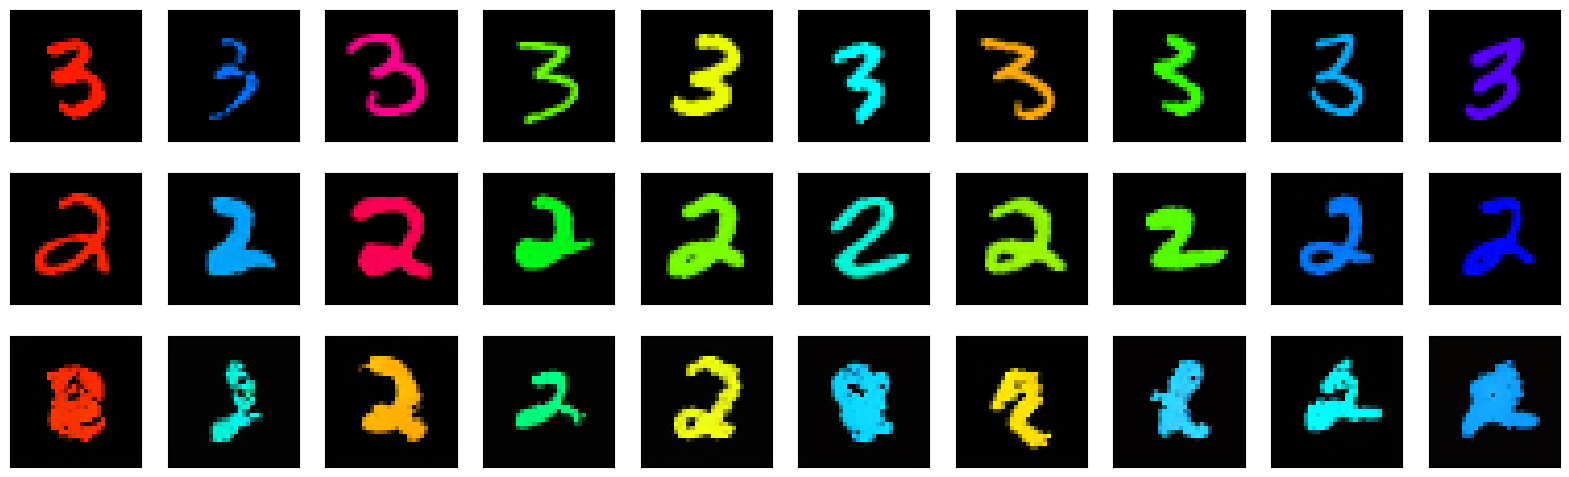

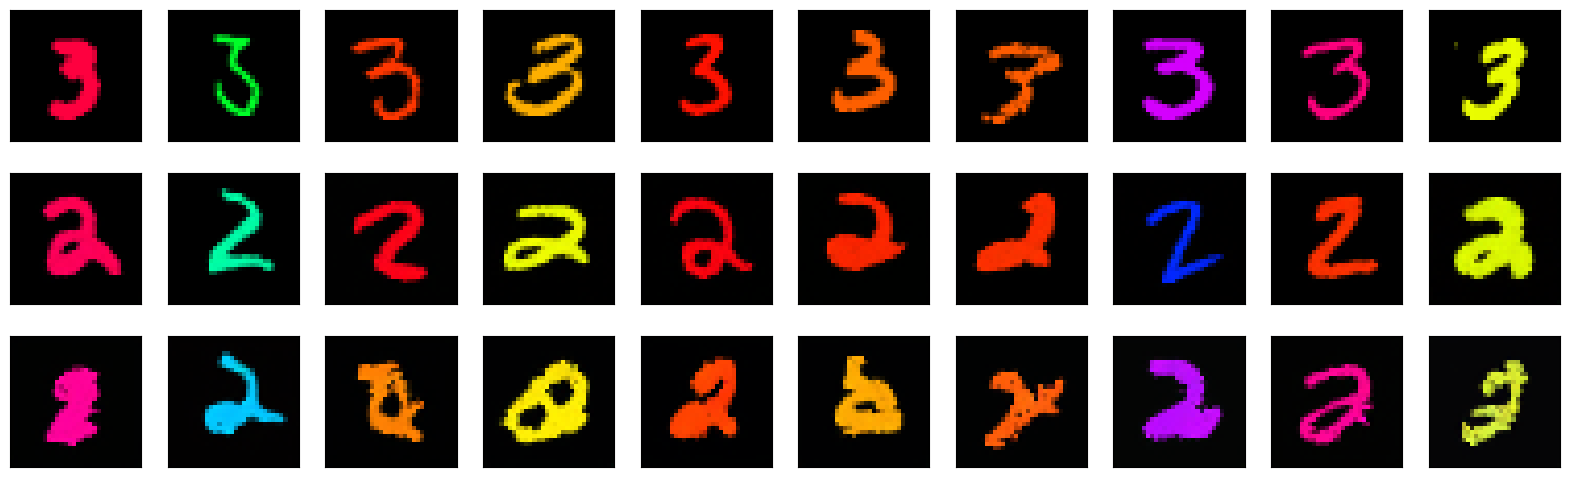

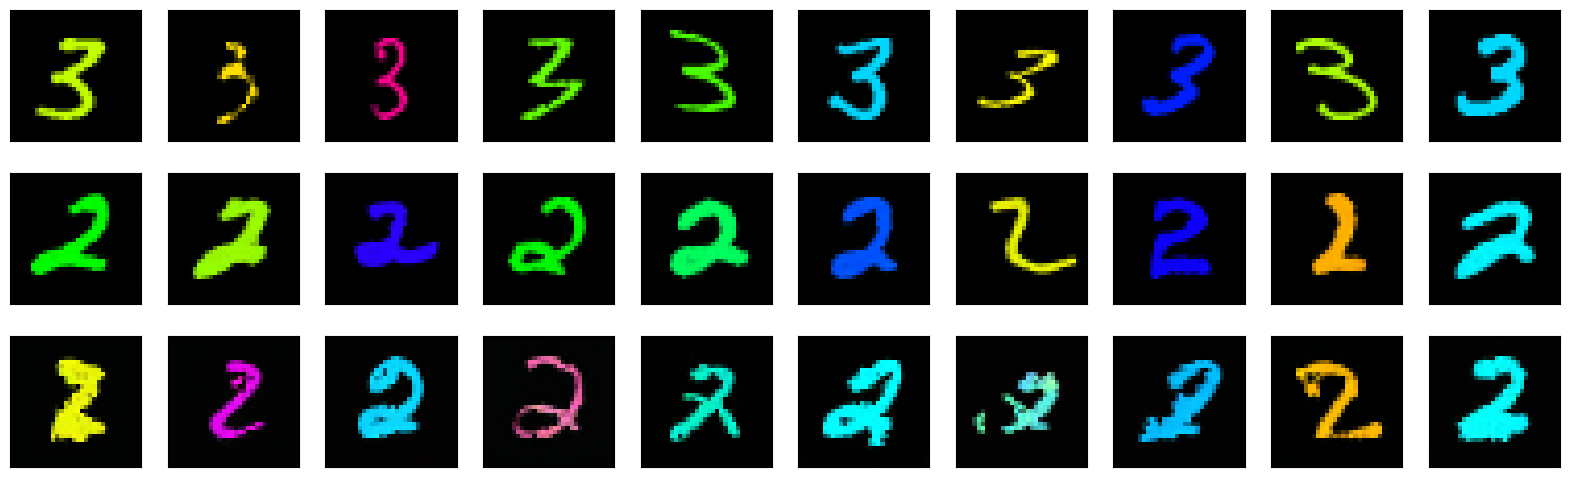

In [ ]:
def plot_comparisons(initial, gen_tr, gen_ddib, N_rows, N_columns):
    
    initial = (initial.permute(0, 2, 3, 1).cpu()+1)* 127.5
    gen_tr = (gen_tr.permute(0, 2, 3, 1).cpu()+1)* 127.5
    gen_ddib = (gen_ddib.permute(0, 2, 3, 1).cpu()+1)* 127.5
    
    for idx_row in range(N_rows):
        fig, axes = plt.subplots(nrows=3, ncols=N_columns, figsize=(int(N_columns*2), 6),
                                subplot_kw={'xticks': [], 'yticks': []})
        for i in range(N_columns):      
            axes[0, (i)].imshow(initial[N_columns*idx_row + i].type(torch.uint8))
            axes[1, (i)].imshow(gen_tr[N_columns*idx_row + i].type(torch.uint8))
            axes[2, (i)].imshow(gen_ddib[N_columns*idx_row + i].type(torch.uint8))


torch.manual_seed(1)

N_rows = 3
N_columns = 10
N_pic = N_rows*N_columns
timesteps = 500

colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
train_loader_3 = torch.utils.data.DataLoader(colored_mnist_3, batch_size=N_pic, shuffle=True, drop_last=True)

model_2.eval()
LTmodel.eval()
with torch.no_grad():

    for batch, _ in train_loader_3:
        img = batch.to(device)
        
        gaussian_diffusion = GaussianDiffusion(timesteps=500, beta_schedule='linear')
        # forward DDPM
        latent_df = gaussian_diffusion.q_sample(img[:N_pic,...], t=torch.tensor([50]).to(device))
        latent_tr = LTmodel(latent_df)
        
        gaussian_diffusion.timesteps = 500
        ddpm_gen_tr = gaussian_diffusion.ddpm_sample(model_2, 32, batch_size=N_pic, channels=3, noise=latent_tr)[-1]

        latent_ddib = gaussian_diffusion.ddim_reverse_sample_loop(model_3, img[:N_pic,...], device, clip_denoised=False)
        ddib_gen = gaussian_diffusion.ddim_sample_loop(model_2, (N_pic, 3, 32, 32), latent_ddib, device, clip_denoised=True).cpu()

        plot_comparisons(batch, ddpm_gen_tr, ddib_gen, N_rows, N_columns)

        break

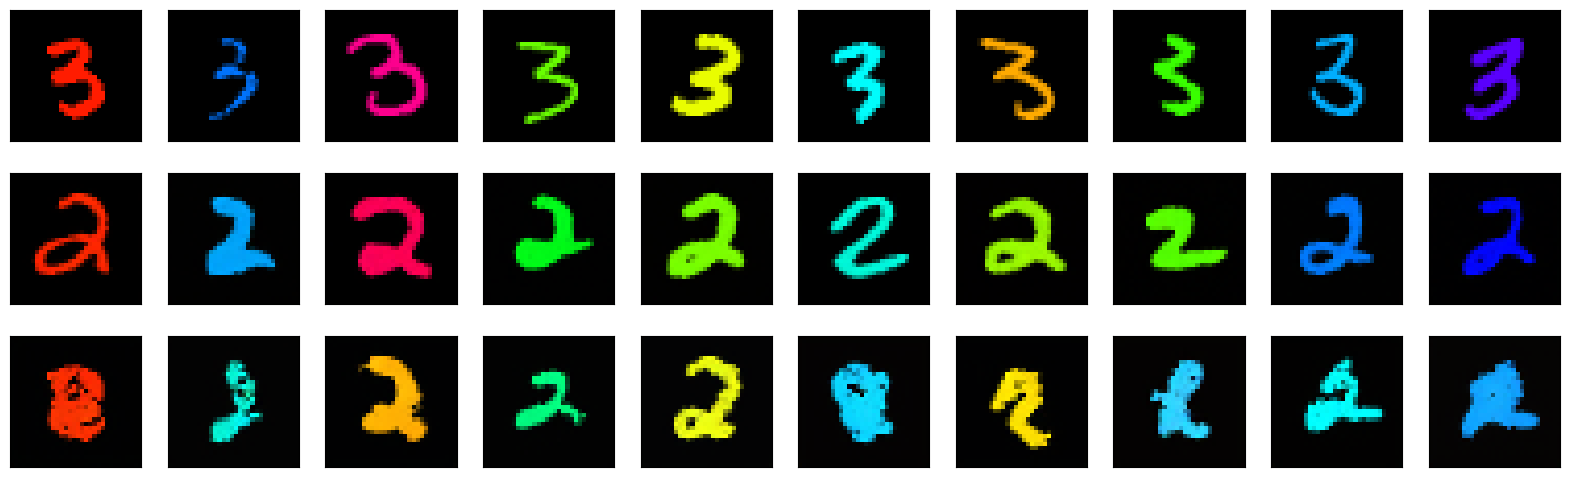

In [28]:
plot_comparisons(batch, ddpm_gen_tr, ddib_gen, N_rows, N_columns)


## Generate multiple timestemps images

In [40]:
torch.manual_seed(1)

import torch
import numpy as np
import os
from PIL import Image

def generate_images(dataloader, LTmodel, model_2, gaussian_diffusion, device, timestep):
    generated_images = []
    
    gray_dir_name = f'generated_data/generated_tr_gray_{timestep}'
    colored_dir_name = f'generated_data/generated_tr_colored_{timestep}'
    os.makedirs(gray_dir_name, exist_ok=True)
    os.makedirs(colored_dir_name, exist_ok=True)

    with torch.no_grad():
        for batch, _ in dataloader:
            img = batch.to(device)
            
            latent_df = gaussian_diffusion.q_sample(img, t=torch.tensor([timestep]).to(device))
            latent_tr = LTmodel(latent_df)

            gaussian_diffusion.timesteps = 500

            transformed_images = gaussian_diffusion.ddpm_sample(
                model_2, 
                32, 
                batch_size=img.shape[0], 
                channels=3, 
                noise=latent_tr
            )[-1]
            
            # Convert to grayscale and resize to 299x299
            transformed_images = ((transformed_images + 1) * 127.5).clamp(0, 255).to('cpu').numpy()
            # Process and save each image
            for idx, img in enumerate(transformed_images):
                pil_img_colored = Image.fromarray(img.transpose(1,2,0).astype(np.uint8), mode='RGB')
                pil_img_colored.save(f'{colored_dir_name}/img_{len(generated_images) + idx}.png')

                # Convert to grayscale by taking mean across channels
                gray_img = img.mean(axis=0)
                # Normalize to ensure full range [0, 255]
                gray_img = ((gray_img - gray_img.min()) / (gray_img.max() - gray_img.min()) * 255)
                # Convert to uint8
                gray_img = gray_img.astype(np.uint8)
                # Create PIL image from grayscale array
                pil_img = Image.fromarray(gray_img, mode='L')
                # Resize
                pil_img = pil_img.resize((299, 299), Image.BILINEAR)
                # Convert to RGB (required for FID)
                pil_img = pil_img.convert('RGB')
                # Save
                pil_img.save(f'{gray_dir_name}/img_{len(generated_images) + idx}.png')


In [41]:
batch_size = 128
colored_mnist_3 = ColoredMNIST(root='./data', train=False, download=True, transform=transform, target_digit=3)
train_loader = torch.utils.data.DataLoader(colored_mnist_3, batch_size=batch_size, shuffle=True)

timestamps = [50, 100, 200, 250, 300, 400, 499]
for t in timestamps:
    generate_images(
        train_loader, 
        LTmodel, 
        model_2, 
        gaussian_diffusion, 
        device, 
        t
    )

sampling loop time step: 100% 500/500 [00:26<00:00, 18.71it/s]
sampling loop time step: 100% 500/500 [00:27<00:00, 18.45it/s]
sampling loop time step: 100% 500/500 [00:27<00:00, 17.94it/s]
sampling loop time step: 100% 500/500 [00:24<00:00, 20.44it/s]
sampling loop time step: 100% 500/500 [00:27<00:00, 17.93it/s]
sampling loop time step: 100% 500/500 [00:27<00:00, 17.93it/s]
sampling loop time step: 100% 500/500 [00:28<00:00, 17.76it/s]
sampling loop time step: 100% 500/500 [00:28<00:00, 17.70it/s]
sampling loop time step: 100% 500/500 [00:28<00:00, 17.66it/s]
sampling loop time step: 100% 500/500 [00:28<00:00, 17.64it/s]
sampling loop time step: 100% 500/500 [00:27<00:00, 17.87it/s]
sampling loop time step: 100% 500/500 [00:24<00:00, 20.29it/s]
sampling loop time step: 100% 500/500 [00:28<00:00, 17.67it/s]
sampling loop time step: 100% 500/500 [00:28<00:00, 17.84it/s]
sampling loop time step: 100% 500/500 [00:27<00:00, 17.88it/s]
sampling loop time step:  25% 124/500 [00:06<00:21, 17.